# ANALYSIS FINAL

## Approach

The first step in our approach was to get our dataset via two main methods: web scraping and API calls. 

We scraped through the top 1,000 movies based on adjusted lifetime gross based on inflation from Box Office Mojo. We were able to get the following information per movie through scraping: movie title, adjusted lifetime gross, lifetime gross, estimated number of tickets and year. We derived our second set of data through API calls on The Movie Database (TMDB). We were able to get IMDB ID, vote count, vote average and popularity. Now to merge those two datasets correctly, we needed a unique identifier like IMDB ID. The ID is not there in the Box Office Mojo but thankfully, the ID is hidden in each of the movie's URL. After merging the datasets, we realized that we were missing scores such as IMDB ratings and meta score. We found those values in another site, OMDB. We were able to get those information through another set of API calls then merging via IMDB ID again.




As most raw data sets need, we had to clean the data. We removed all movies without budget indicated. We decided to focus on just the top movies from the last decade to ensure data relevancy.

We then finally started to answer the questions that we want to address in this project through data analysis and visualization.

## Import and install necessary packages

In [151]:
### Import necessary packages ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Prevent pandas from showing values in exponential form ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
conda install tqdm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [36]:
conda install -c conda-forge wordcloud

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [28]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

## Get merged and clean data

In [4]:
## The data here are the merged ones from API calls and scraping after cleaning ##
df = pd.read_csv('merged_raw_data_clean_decade.csv', encoding='latin-1')

In [145]:
df.head()

,Rank,Title,Adj. Lifetime Gross,Lifetime Gross,Est. Num Tickets,Year,Budget,Director,Actor,Genre,IMDB ID,Vote Count,Vote Average,Popularity,IMDB Rating,Meta Score
0,11,Star Wars: Episode VII - The Force Awakens,1013038460.000,936662200.000,108115100.000,2015,245000000.000,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Action, Adventure, Sci-Fi",tt2488496,13865,7.400,28.812,7.900,81.000
1,16,Avengers: Endgame,892669600.000,858373000.000,95268900.000,2019,356000000.000,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...","Action, Adventure, Drama, Sci-Fi",tt4154796,11389,8.300,38.570,8.500,78.000
2,29,The Avengers,720376800.000,623357900.000,76881200.000,2012,220000000.000,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...","Action, Adventure, Sci-Fi",tt0848228,21584,7.700,37.337,8.000,69.000
3,30,Jurassic World,719518500.000,652270660.000,76789600.000,2015,150000000.000,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","Action, Adventure, Sci-Fi",tt0369610,15085,6.600,25.921,7.000,59.000
4,31,Black Panther,714671400.000,700059600.000,76272300.000,2018,202003950.000,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Action, Adventure, Sci-Fi",tt1825683,14336,7.400,34.269,7.300,88.000


In [6]:
### Create new dataframe to only include movies in the last decade ###

df10 = df.loc[(df['Year'] >= 2010)]

In [7]:
df10.head()

,Rank,Title,Adj. Lifetime Gross,Lifetime Gross,Est. Num Tickets,Year,Budget,Director,Actor,Genre,IMDB ID,Vote Count,Vote Average,Popularity,IMDB Rating,Meta Score
0,11,Star Wars: Episode VII - The Force Awakens,1.013038e+09,936662200.0,108115100.0,2015,245000000.0,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Action, Adventure, Sci-Fi",tt2488496,13865,7.4,28.812,7.9,81.0
1,16,Avengers: Endgame,8.926696e+08,858373000.0,95268900.0,2019,356000000.0,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...","Action, Adventure, Drama, Sci-Fi",tt4154796,11389,8.3,38.570,8.5,78.0
2,29,The Avengers,7.203768e+08,623357900.0,76881200.0,2012,220000000.0,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...","Action, Adventure, Sci-Fi",tt0848228,21584,7.7,37.337,8.0,69.0
3,30,Jurassic World,7.195185e+08,652270660.0,76789600.0,2015,150000000.0,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","Action, Adventure, Sci-Fi",tt0369610,15085,6.6,25.921,7.0,59.0
4,31,Black Panther,7.146714e+08,700059600.0,76272300.0,2018,202003950.0,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Action, Adventure, Sci-Fi",tt1825683,14336,7.4,34.269,7.3,88.0


## Functions for reuse

In [15]:
def final_clean(dirty_column):
   
    """ 
    This function is used to clean a list inside a dataframe. Use case is if the list inside a dataframe has inconsistent spacing after a comma, which would result to dirty strings after you split the list. Finally, this removes duplicates to return unique values.
         
    Parameters: 
        dirty_column: The column in a dataframe that you want to clean.
          
    Returns: 
        clean_list: A clean list with consistent spacing and commas for better splitting into separate items.
    """

    dirty_list = dirty_column
    dirty_list = list(dirty_list)
    dirty_list = ','.join(dirty_list)
    dirty_list = dirty_list.replace(",",", ")
    dirty_list = dirty_list.replace("  ","")
    dirty_list = dirty_list.replace(",",", ")
    dirty_list = dirty_list.replace("  "," ")
    clean_list = dirty_list.split(", ")
    clean_list = list(set(clean_list))
    
    return clean_list

In [19]:
def word_cloud(list_words):
    
    """ 
    This function is used to clean a column for word cloud graphing because word cloud recognizes each word, which means it separates names into first and last names. Word cloud is better if it includes the whole name.       
        Parameters: 
            list_words: The column in a dataframe that you want to clean and prepare for word cloud visualization.
          
        Returns: 
            clean_list: A clean list with names intact.
    """
    
    dirty_list = list_words
    dirty_list = list(dirty_list)
    dirty_list = ','.join(dirty_list)
    dirty_list = dirty_list.replace(",",", ")
    dirty_list = dirty_list.replace("  ","")
    dirty_list = dirty_list.replace(",",", ")
    dirty_list = dirty_list.replace("  "," ")
    final_list = dirty_list.replace(" ","")
    
    return final_list

In [143]:
def get_averages(df):
    """ 
    This function computes for the averages of lifetime gross, vote count, popularity and vote acount for any category
        
        Parameters: 
            df: Input the df where you want this computed. Can be actors, directors or genres.
          
        Returns: 
            Does not return a variable but automatically does the calculation.
    """
    
    df['Adj. Lifetime Gross Average'] = df['Adj. Lifetime Gross'] / df['Movie Count']
    df['Vote Count Average'] = df['Vote Count'] / df['Movie Count']
    df['Popularity Average'] = df['Popularity'] / df['Movie Count']
    df['Vote Average'] = df['Vote Average'] / df['Movie Count']

In [155]:
### This function prevents numbers to show in exponential form when visualizing data. ###
### This function was copied from this link: https://dfrieds.com/data-visualizations/how-format-large-tick-values.html ###

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

## Movie Actors Analysis

In [124]:
### Create new dataframe based on new list ###

### Used final_clean function to clean the actor column ###
actor_list = final_clean(df10['Actor'])
actors_df = pd.DataFrame(actor_list,columns=["Actor"]) 

In [125]:
actors_df.head()

,Actor
0,Kyle Chandler
1,Ginnifer Goodwin
2,Keanu Reeves
3,Ed Helms
4,Zac Efron


In [126]:
### Go through each actor in the list then checks which movies the actor was in ###   

### Loop through each actor but add progress bar ###
for actor in tqdm(actor_list):
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0
    movie_count = 0
    
    ### Loop through each movie in the last decade ###
    for index, row in df10.iterrows():
        
        ### If actor is present in movie, count the total gross and total movie the actor is in ###
        if actor in row['Actor']:
            gross = row['Adj. Lifetime Gross'] + gross
            vote_count = row['Vote Count'] + vote_count
            popularity = row['Popularity'] + popularity
            vote_average = row['Vote Average'] + vote_average
            movie_count += 1
    
    ### Save the values in the actor df ###
    actors_df.loc[actors_df['Actor'] == actor, 'Adj. Lifetime Gross'] = gross
    actors_df.loc[actors_df['Actor'] == actor, 'Vote Count'] = vote_count
    actors_df.loc[actors_df['Actor'] == actor, 'Popularity'] = popularity
    actors_df.loc[actors_df['Actor'] == actor, 'Vote Average'] = vote_average
    actors_df.loc[actors_df['Actor'] == actor, 'Movie Count'] = movie_count
    movie_count = 0
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0

In [127]:
actors_df.head()

,Actor,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count
0,Kyle Chandler,148111580.0,4381.0,12.012,6.7,1.0
1,Ginnifer Goodwin,371109150.0,11107.0,44.800,7.7,1.0
2,Keanu Reeves,177849150.0,3949.0,37.874,7.1,1.0
3,Ed Helms,727244120.0,14823.0,43.923,19.6,3.0
4,Zac Efron,599546020.0,12992.0,45.904,20.6,3.0


In [114]:
### Use get_averages function to get actor value averages ###

get_averages(actors_df)

In [147]:
actors_df.head()

,Actor,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count,Adj. Lifetime Gross Average,Vote Count Average,Popularity Average
0,Kyle Chandler,148111580.000,4381.000,12.012,6.700,1.000,148111580.000,4381.000,12.012
1,Ginnifer Goodwin,371109150.000,11107.000,44.800,7.700,1.000,371109150.000,11107.000,44.800
2,Keanu Reeves,177849150.000,3949.000,37.874,7.100,1.000,177849150.000,3949.000,37.874
3,Ed Helms,727244120.000,14823.000,43.923,6.533,3.000,242414706.667,4941.000,14.641
4,Zac Efron,599546020.000,12992.000,45.904,6.867,3.000,199848673.333,4330.667,15.301


In [148]:
### Cleaning/sorting data before graphing them ###

actors_df_top_grossing = actors_df.sort_values(by='Adj. Lifetime Gross', ascending=False)
actors_df_top_20_grossing = actors_df_top_grossing.head(20)
actors_df_top_20_grossing = actors_df_top_20_grossing.sort_values(by="Adj. Lifetime Gross", ascending=False)

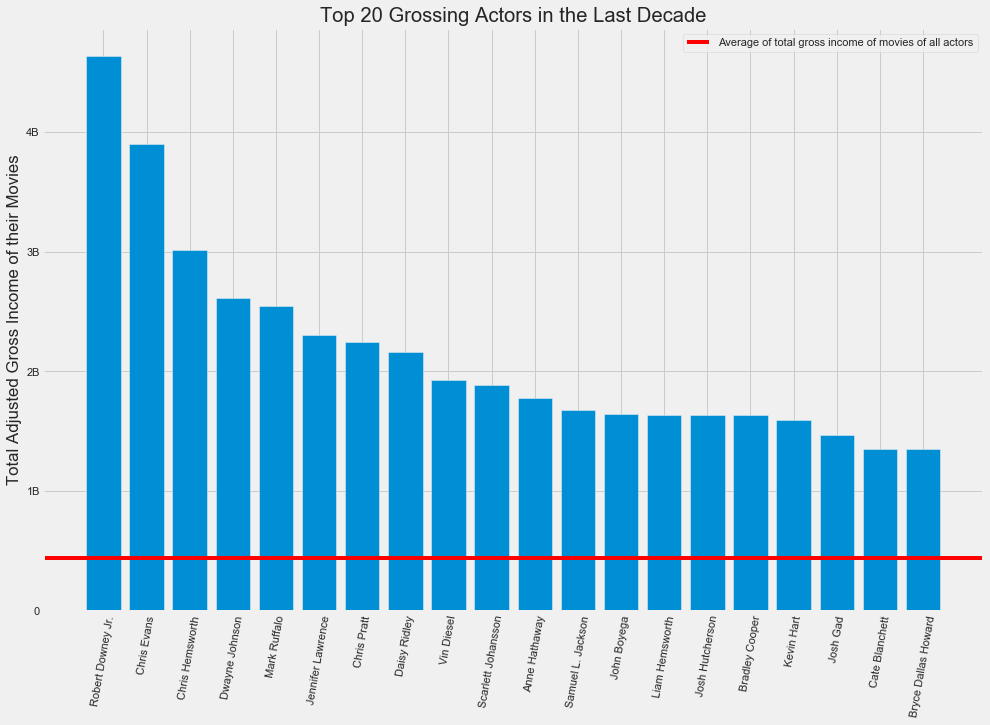

In [154]:


### Use built in matploblib template ###
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(actors_df_top_20_grossing["Actor"], actors_df_top_20_grossing["Adj. Lifetime Gross"])
ax.axhline(actors_df["Adj. Lifetime Gross"].mean(), color="red", label="Average of total gross income of movies of all actors")

ax.set_xticklabels(actors_df_top_20_grossing["Actor"], rotation=80)

ax.set_ylabel("Total Adjusted Gross Income of their Movies")
ax.set_title('Top 20 Grossing Actors in the Last Decade')
ax.legend()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));


plt.show()

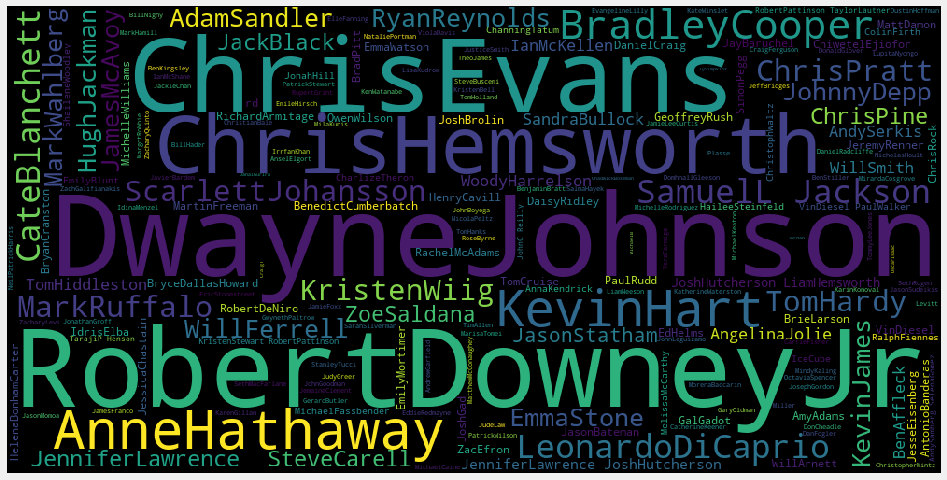

In [38]:
word_actors = word_cloud(df10['Actor'])

import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Convert list to string and generate graph ###
unique_string=(" ").join(word_actors)
wordcloud = WordCloud(width = 1000, height = 500, background_color="black").generate(word_actors)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()
plt.close()

## Movie Directors Analysis

In [135]:
### Create new dataframe based on new list ###

### Used final_clean function to clean the director column ###
director_list = final_clean(df10['Director'])
directors_df = pd.DataFrame(director_list,columns=["Director"]) 

In [136]:
directors_df.head()

,Director
0,Rawson Marshall Thurber
1,Conrad Vernon
2,Andy Muschietti
3,Elizabeth Banks
4,Paul Weitz


In [137]:
### Go through each director in the list then checks which movies the actor was in ###   

### Loop through each director but add progress bar ###
for director in tqdm(director_list):
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0
    movie_count = 0
    
    ### Loop through each movie in the last decade ###
    for index, row in df10.iterrows():
        
        ### If director is present in movie, count the total gross and total movie the director directed ###
        if director in row['Director']:
            gross = row['Adj. Lifetime Gross'] + gross
            vote_count = row['Vote Count'] + vote_count
            popularity = row['Popularity'] + popularity
            vote_average = row['Vote Average'] + vote_average
            movie_count += 1
    
    ### Save the values in the director df ###
    directors_df.loc[directors_df['Director'] == director, 'Adj. Lifetime Gross'] = gross
    directors_df.loc[directors_df['Director'] == director, 'Vote Count'] = vote_count
    directors_df.loc[directors_df['Director'] == director, 'Popularity'] = popularity
    directors_df.loc[directors_df['Director'] == director, 'Vote Average'] = vote_average
    directors_df.loc[directors_df['Director'] == director, 'Movie Count'] = movie_count
    movie_count = 0
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0

In [138]:
directors_df.head()

,Director,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count
0,Rawson Marshall Thurber,317068620.0,9406.0,27.790,13.1,2.0
1,Conrad Vernon,252115780.0,3813.0,15.368,6.5,1.0
2,Andy Muschietti,561455070.0,16038.0,52.068,14.0,2.0
3,Elizabeth Banks,200786910.0,3945.0,26.860,6.9,1.0
4,Paul Weitz,175240540.0,2122.0,9.142,5.6,1.0


In [139]:
### Use get_averages function to get directors value averages ###

get_averages(directors_df)

In [140]:
directors_df.head()

,Director,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count,Adj. Lifetime Gross Average,Vote Count Average,Popularity Average
0,Rawson Marshall Thurber,317068620.0,9406.0,27.790,6.55,2.0,158534310.0,4703.0,13.895
1,Conrad Vernon,252115780.0,3813.0,15.368,6.50,1.0,252115780.0,3813.0,15.368
2,Andy Muschietti,561455070.0,16038.0,52.068,7.00,2.0,280727535.0,8019.0,26.034
3,Elizabeth Banks,200786910.0,3945.0,26.860,6.90,1.0,200786910.0,3945.0,26.860
4,Paul Weitz,175240540.0,2122.0,9.142,5.60,1.0,175240540.0,2122.0,9.142


In [45]:
### Cleaning/sorting data before graphing them ###

directors_df_top_grossing = directors_df.sort_values(by='Adj. Lifetime Gross Average', ascending=False)
directors_df_top_20_grossing = directors_df_top_grossing.head(20)
directors_df_top_20_grossing = directors_df_top_20_grossing.sort_values(by="Adj. Lifetime Gross Average", ascending=False)

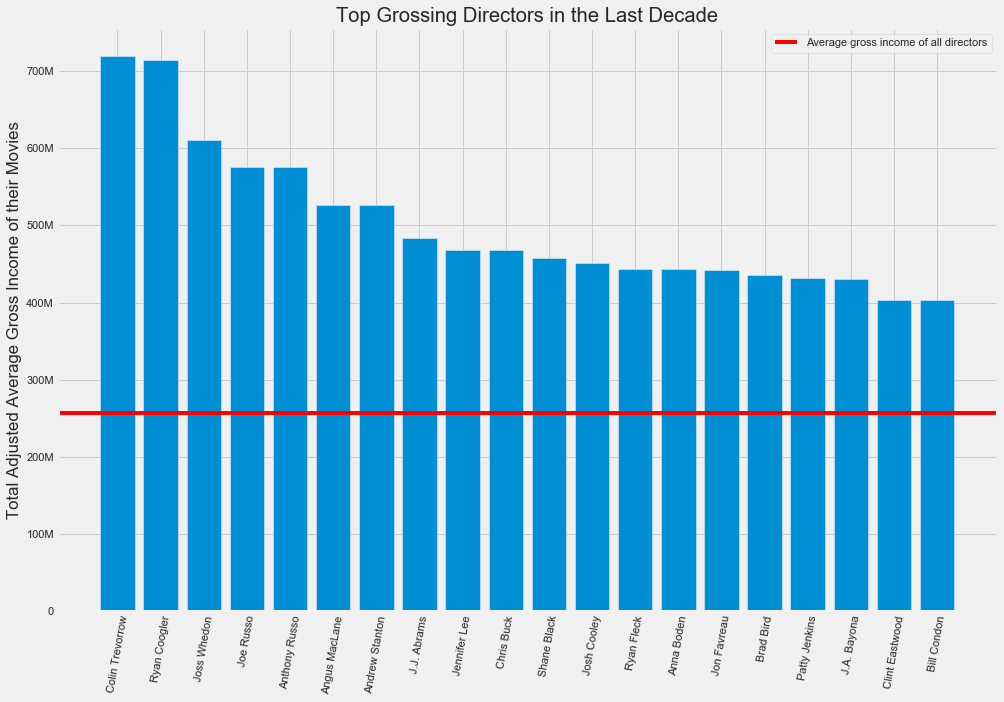

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Use built in matploblib template ###
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(directors_df_top_20_grossing["Director"], directors_df_top_20_grossing["Adj. Lifetime Gross Average"])
ax.axhline(directors_df["Adj. Lifetime Gross Average"].mean(), color="red", label="Average gross income of all directors")

ax.set_xticklabels(directors_df_top_20_grossing["Director"], rotation=80)

ax.set_ylabel("Total Adjusted Average Gross Income of their Movies")
ax.set_title('Top Grossing Directors in the Last Decade')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

ax.legend()

plt.show()

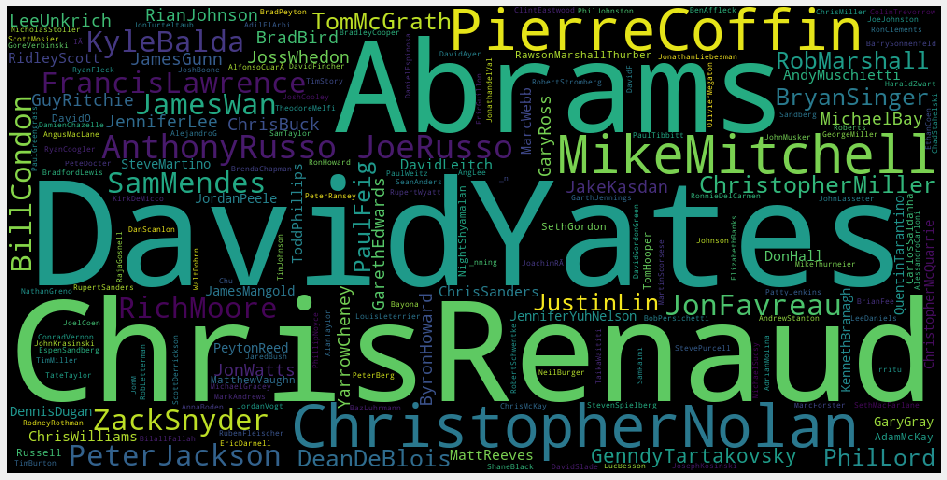

In [51]:
word_directors = word_cloud(df10['Director'])

import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Convert list to string and generate graph ###
unique_string=(" ").join(word_directors)
wordcloud = WordCloud(width = 1000, height = 500, background_color="black").generate(word_directors)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()
plt.close()

## Movie Genres Analysis

In [53]:
### Create new dataframe based on new list ###

### Used final_clean function to clean the genre column ###
genre_list = final_clean(df10['Genre'])
genres_df = pd.DataFrame(genre_list,columns=["Genre"]) 

In [54]:
genres_df.head()

,Genre
0,Mystery
1,Comedy
2,History
3,Drama
4,Romance


In [55]:
### Go through each actor in the list then checks which movies the actor was in ###   

### Loop through each genre but add progress bar ###
for genre in tqdm(genre_list):
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0
    movie_count = 0
    
    ### Loop through each movie in the last decade ###
    for index, row in df10.iterrows():
        
        ### If movie is of that particular genre, count the total gross and total movie ###
        if genre in row['Genre']:
            gross = row['Adj. Lifetime Gross'] + gross
            vote_count = row['Vote Count'] + vote_count
            popularity = row['Popularity'] + popularity
            vote_average = row['Vote Average'] + vote_average
            movie_count += 1
    
    ### Save the values in the genre df ###
    genres_df.loc[genres_df['Genre'] == genre, 'Adj. Lifetime Gross'] = gross
    genres_df.loc[genres_df['Genre'] == genre, 'Vote Count'] = vote_count
    genres_df.loc[genres_df['Genre'] == genre, 'Popularity'] = popularity
    genres_df.loc[genres_df['Genre'] == genre, 'Vote Average'] = vote_average
    genres_df.loc[genres_df['Genre'] == genre, 'Movie Count'] = movie_count
    movie_count = 0
    gross = 0
    vote_count = 0
    popularity = 0 
    vote_average = 0

In [56]:
genres_df.head()

,Genre,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count
0,Mystery,3.407277e+09,134486.0,393.565,117.2,16.0
1,Comedy,2.149602e+10,507426.0,2121.160,606.6,90.0
2,History,1.315204e+09,42182.0,131.552,52.5,7.0
3,Drama,1.342217e+10,401090.0,1413.263,416.4,58.0
4,Romance,5.198265e+09,133728.0,461.303,148.3,22.0


In [141]:
### Use get_averages function to get genre value averages ###

get_averages(genres_df)

In [142]:
genres_df.head()

,Genre,Adj. Lifetime Gross,Vote Count,Popularity,Vote Average,Movie Count,Adj. Lifetime Gross Average,Vote Count Average,Popularity Average
0,Mystery,3.407277e+09,134486.0,393.565,0.457813,16.0,2.129548e+08,8405.375000,24.597813
1,Comedy,2.149602e+10,507426.0,2121.160,0.074889,90.0,2.388447e+08,5638.066667,23.568444
2,History,1.315204e+09,42182.0,131.552,1.071429,7.0,1.878863e+08,6026.000000,18.793143
3,Drama,1.342217e+10,401090.0,1413.263,0.123781,58.0,2.314166e+08,6915.344828,24.366603
4,Romance,5.198265e+09,133728.0,461.303,0.306405,22.0,2.362848e+08,6078.545455,20.968318


In [59]:
### Cleaning/sorting data before graphing them ###

genres_df_top_grossing = genres_df.sort_values(by='Adj. Lifetime Gross', ascending=False)
genres_df_top_20_grossing = genres_df_top_grossing.head(20)
genres_df_top_20_grossing = genres_df_top_20_grossing.sort_values(by="Adj. Lifetime Gross", ascending=False)

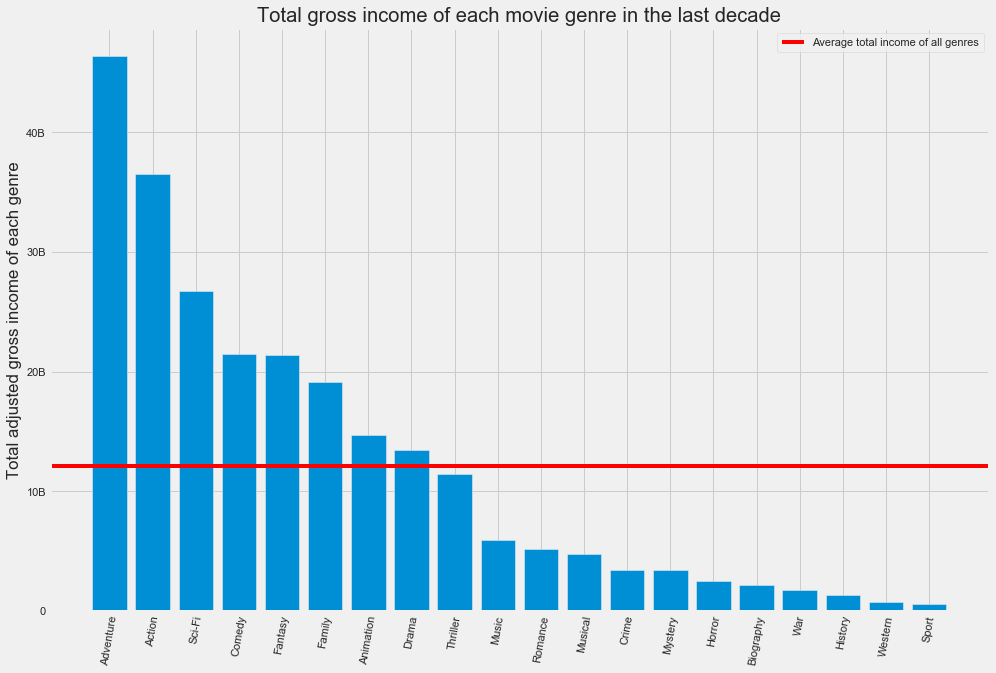

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Use built in matploblib template ###
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_df_top_20_grossing["Genre"], genres_df_top_20_grossing["Adj. Lifetime Gross"])
ax.axhline(genres_df["Adj. Lifetime Gross"].mean(), color="red", label="Average total income of all genres")

ax.set_xticklabels(genres_df_top_20_grossing["Genre"], rotation=80)

ax.set_ylabel("Total adjusted gross income of each genre")
ax.set_title('Total gross income of each movie genre in the last decade')
ax.legend()

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

plt.show()

In [62]:
## Need to create a bigger genre dataframe for Box Plot Analysis ##

main_genre_df = pd.DataFrame(columns=['Genre', 'Adj. Lifetime Gross','IMDB Rating', 'Meta Score'])

In [65]:
## This adds a row per genre per movie then adds additional values ##

## Go through each genre ##
for genre in tqdm(genre_list):
    
    ## Go through each movie ##
    for index, row in df.iterrows():
        
        ## Check if the movie is of that particular genre ##
        ## If it is, add the values ##
        if genre in row['Genre']:
            main_genre_df = main_genre_df.append({'Genre' : genre, 'Adj. Lifetime Gross' : row['Adj. Lifetime Gross'] , 'IMDB Rating' : row['IMDB Rating'], 'Meta Score' : row['Meta Score']} , ignore_index=True)

In [69]:
main_genre_df.head()

,Genre,Adj. Lifetime Gross,IMDB Rating,Meta Score
0,Mystery,451701470.0,8.1,87.0
1,Mystery,371109150.0,8.0,78.0
2,Mystery,348589300.0,7.7,65.0
3,Mystery,222551550.0,7.5,48.0
4,Mystery,214142910.0,8.4,81.0


In [67]:
main_genre_df.to_csv (r'genres_raw_data_main.csv', index = False, header=True)

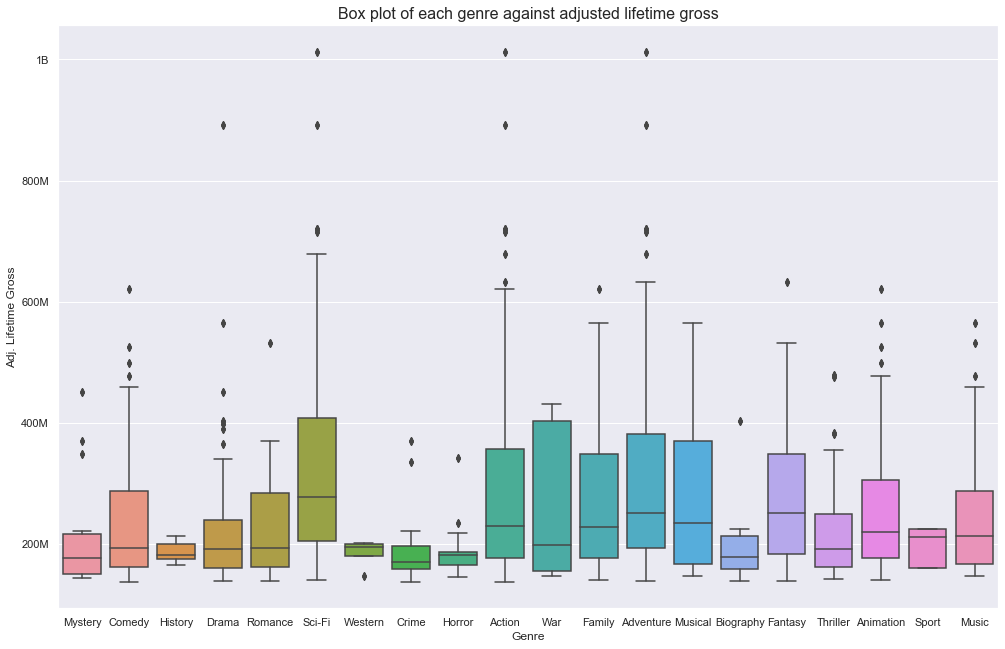

In [177]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x=main_genre_df['Genre'], y=main_genre_df['Adj. Lifetime Gross'])
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_title('Box plot of each genre against adjusted lifetime gross', fontsize=16)

ax

## Movie Origin Analysis

In [70]:
## Create new dataframe to only include top 25 films of this decade ##

top25df = df10.sort_values(by="Adj. Lifetime Gross", ascending=False).head(25)

In [71]:
top25df.head()

,Rank,Title,Adj. Lifetime Gross,Lifetime Gross,Est. Num Tickets,Year,Budget,Director,Actor,Genre,IMDB ID,Vote Count,Vote Average,Popularity,IMDB Rating,Meta Score
0,11,Star Wars: Episode VII - The Force Awakens,1.013038e+09,936662200.0,108115100.0,2015,245000000.0,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Action, Adventure, Sci-Fi",tt2488496,13865,7.4,28.812,7.9,81.0
1,16,Avengers: Endgame,8.926696e+08,858373000.0,95268900.0,2019,356000000.0,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...","Action, Adventure, Drama, Sci-Fi",tt4154796,11389,8.3,38.570,8.5,78.0
2,29,The Avengers,7.203768e+08,623357900.0,76881200.0,2012,220000000.0,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...","Action, Adventure, Sci-Fi",tt0848228,21584,7.7,37.337,8.0,69.0
3,30,Jurassic World,7.195185e+08,652270660.0,76789600.0,2015,150000000.0,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","Action, Adventure, Sci-Fi",tt0369610,15085,6.6,25.921,7.0,59.0
4,31,Black Panther,7.146714e+08,700059600.0,76272300.0,2018,202003950.0,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Action, Adventure, Sci-Fi",tt1825683,14336,7.4,34.269,7.3,88.0


In [72]:
## Load data with manually identified IP content ##

content_df = pd.read_csv('ip_raw_data.csv', encoding='latin-1')

In [75]:
content_df.head()

,Rank,Title,IP,Adj. Lifetime Gross,Lifetime Gross,Est. Num Tickets,Year,Budget,Director,Actor,Genre,IMDB ID,Vote Count,Vote Average,Popularity
0,11,Star Wars: Episode VII - The Force Awakens,Existing IP,1013038460,936662200,108115100,2015,245000000,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Action, Adventure, Sci-Fi",tt2488496,13865,7.4,28.812
1,16,Avengers: Endgame,Existing IP,892669600,858373000,95268900,2019,356000000,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...","Action, Adventure, Drama, Sci-Fi",tt4154796,11389,8.3,38.570
2,29,The Avengers,Existing IP,720376800,623357900,76881200,2012,220000000,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...","Action, Adventure, Sci-Fi",tt0848228,21584,7.7,37.337
3,30,Jurassic World,Existing IP,719518500,652270660,76789600,2015,150000000,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","Action, Adventure, Sci-Fi",tt0369610,15085,6.6,25.921
4,31,Black Panther,Existing IP,714671400,700059600,76272300,2018,202003950,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Action, Adventure, Sci-Fi",tt1825683,14336,7.4,34.269


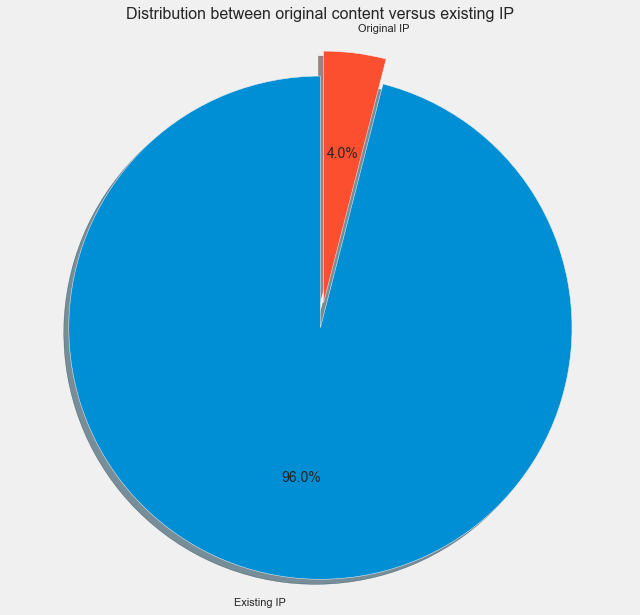

In [193]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

labels = 'Existing IP', 'Original IP'
sizes = [24, 1]
explode = (0, 0.1) 

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  
ax.set_title('Distribution between original content versus existing IP', fontsize=16)

plt.show()

## Correlation Analysis

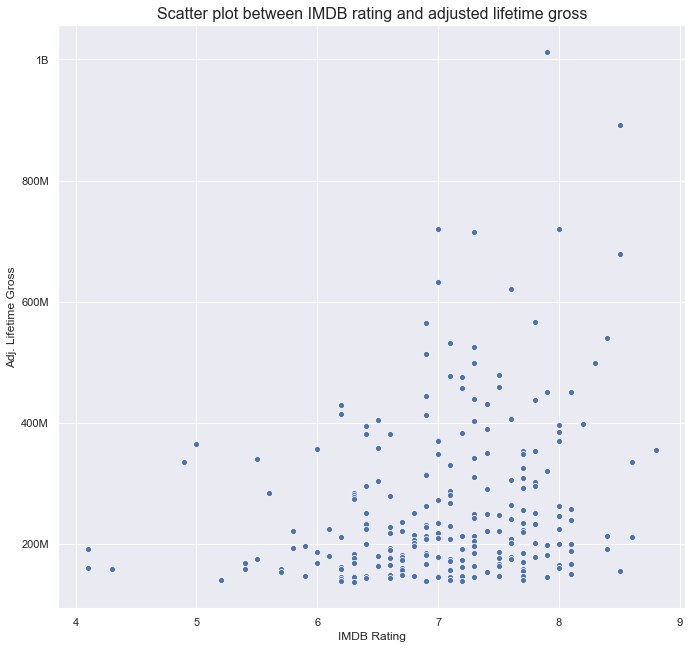

In [182]:
## Correlation between IMDB rating and Adjusted Lifetime Gross Income ##

fig, ax = plt.subplots(figsize=(10,10))
sns.set()

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_title('Scatter plot between IMDB rating and adjusted lifetime gross', fontsize=16)

sns.scatterplot(df['IMDB Rating'], df['Adj. Lifetime Gross'])

ax

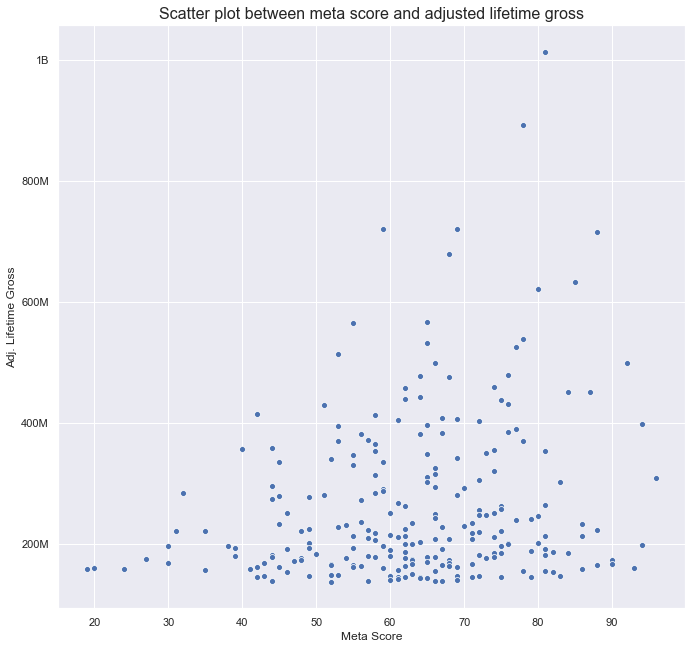

In [183]:
## Correlation between Meta Score and Adjusted Lifetime Gross Income ##

fig, ax = plt.subplots(figsize=(10,10))
sns.set()

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

sns.scatterplot(df['Meta Score'], df['Adj. Lifetime Gross'])
ax.set_title('Scatter plot between meta score and adjusted lifetime gross', fontsize=16)

ax

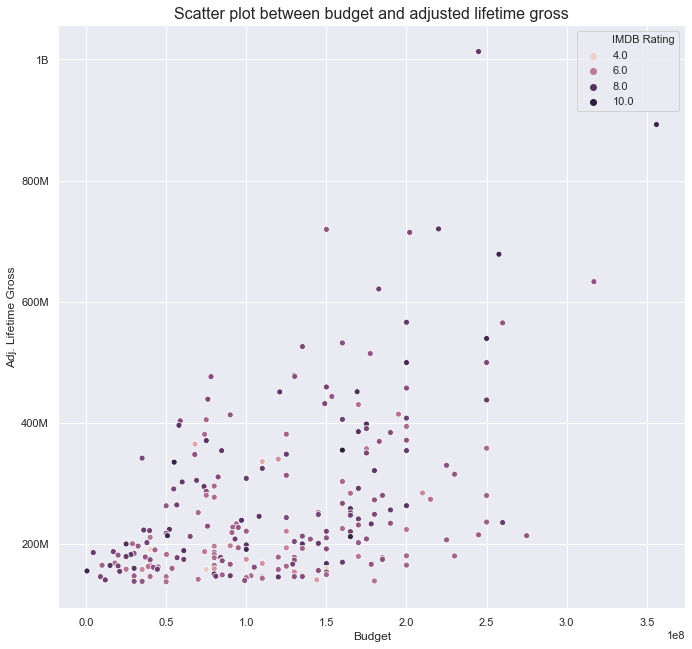

In [184]:
## Correlation between budget and Adjusted Lifetime Gross Income ##

fig, ax = plt.subplots(figsize=(10,10))
sns.set()

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_title('Scatter plot between budget and adjusted lifetime gross', fontsize=16)

sns.scatterplot(df['Budget'], df['Adj. Lifetime Gross'], hue = df['IMDB Rating'],)
ax

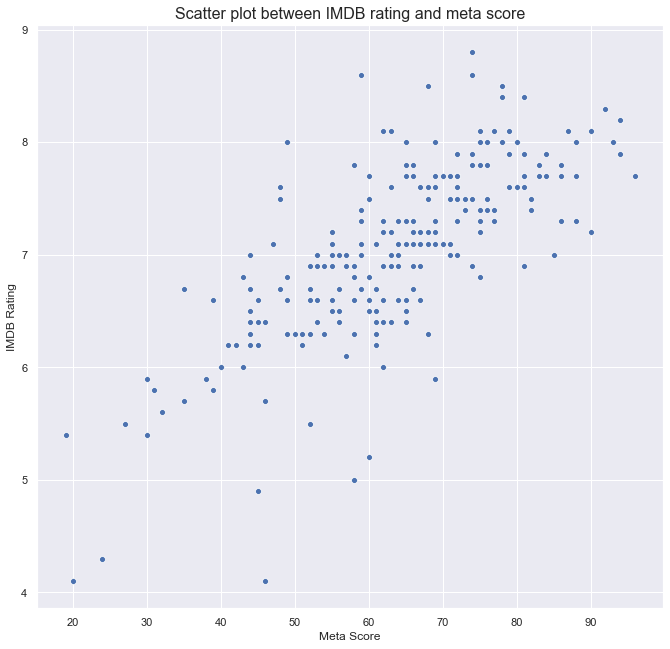

In [185]:
## Correlation between budget and Adjusted Lifetime Gross Income ##

fig, ax = plt.subplots(figsize=(10,10))
plt.style.use('fivethirtyeight')

sns.set()

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_title('Scatter plot between IMDB rating and meta score', fontsize=16)

sns.scatterplot(df['Meta Score'], df['IMDB Rating'])
ax


## Distribution Analysis

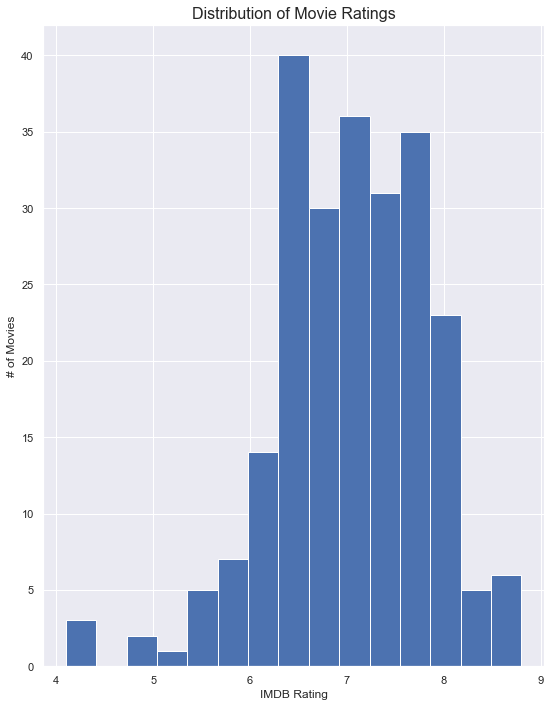

In [188]:
### Histogram to show distribution of the number of movies against IMDB rating ###

fig, ax = plt.subplots(figsize=(8.,11))
ax.hist(df['IMDB Rating'], bins=15)

ax.set_xlabel('IMDB Rating')
ax.set_ylabel('# of Movies')
ax.set_title("Distribution of Movie Ratings", fontsize = 16)

plt.show()

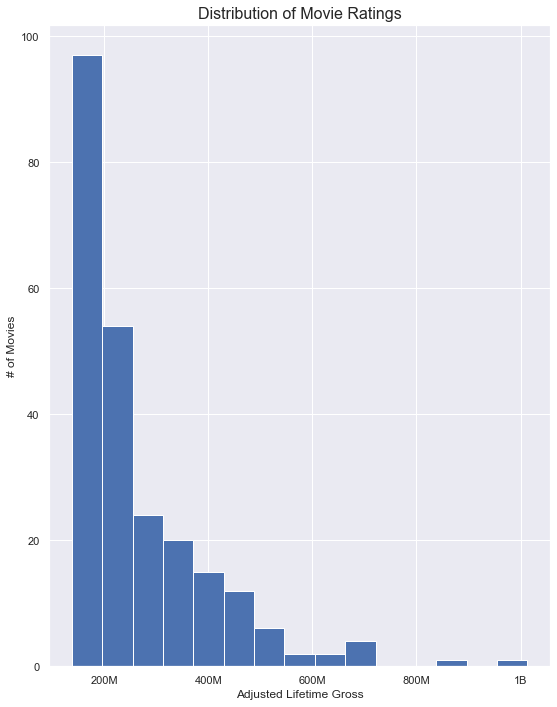

In [190]:
### Histogram to show distribution of the number of movies against adjusted lifetime gross ###

fig, ax = plt.subplots(figsize=(8.,11))
# Plot a histogram of "Weight" for mens_rowing
ax.hist(df['Adj. Lifetime Gross'], bins=15)

ax.set_xlabel('Adjusted Lifetime Gross')
ax.set_ylabel('# of Movies')
ax.set_title("Distribution of Movie Ratings", fontsize = 16)

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

